# Business Objective:
    To get the nearest email template required by the user based on the key words specified by the user.

## Steps which are followed:

    Scrapping most used email templates from websites data set size is subjective to individual team and to the NLP model requirement.

### 1. Loading the Required libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Loading  lexical database.
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Sujay
[nltk_data]     Patil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2. Uploading the json file

In [3]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [4]:
data = load_doc("D:\\DATASCIENCEsoftware\\project\\intents.json")

In [5]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [6]:
# users intents 
df1 = frame_data('questions','labels',True)
df1

questions                  labels
0                  Leave of Absence Request      Leave_Letter_Email
1   Medical Leave of Absence Request Letter      Leave_Letter_Email
2                  Annual leave application      Leave_Letter_Email
3               Maternity leave application      Leave_Letter_Email
4               Paternity leave application      Leave_Letter_Email
..                                      ...                     ...
92                  Formal Job Offer Letter  Job_Offer_Letter_Email
93               Developer Job Offer Letter  Job_Offer_Letter_Email
94          Internal Promotion Offer Letter  Job_Offer_Letter_Email
95      Part time to Full time Offer Letter  Job_Offer_Letter_Email
96                   Sales Job Offer Letter  Job_Offer_Letter_Email

[97 rows x 2 columns]

### 3. Exploratory Data Analysis

In [7]:
#!pip install texthero

In [8]:
import texthero as hero

In [9]:
# First few dataset
df1.head()

questions              labels
0                 Leave of Absence Request  Leave_Letter_Email
1  Medical Leave of Absence Request Letter  Leave_Letter_Email
2                 Annual leave application  Leave_Letter_Email
3              Maternity leave application  Leave_Letter_Email
4              Paternity leave application  Leave_Letter_Email

In [10]:
# count the number of rows in dataset
df1.count()

questions    97
labels       97
dtype: int64

In [11]:
# Statistical Analysis
df1.describe()

questions           labels
count         97               97
unique        97                8
top           Hi  Business_Letter
freq           1               32

In [12]:
df1.labels.value_counts(sort=False)

Business_Letter                      32
Job_Offer_Letter_Email                5
Information_Request_Letter           10
Job_Invitation_Email                  5
Employee_Letters                      6
Leave_Letter_Email                   14
Application_Letter                   10
Job_Search_and_Networking_Letters    15
Name: labels, dtype: int64

In [13]:
# Bot response
df2 = frame_data('response','labels',False)
df2.head()

response              labels
0                Sorry, kindly rephrase the question            confused
1                      Sorry, can not understand you            confused
2                    Please give me more information            confused
3                              Not sure I understand            confused
4  Dear ABC,\n I would like to request a XXX days...  Leave_Letter_Email

### 4. Visualization

#### i.) Text cleaning, TF-IDF representation and visualization

In [14]:
df1['pca'] = (
   df1['questions']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df1, 'pca', color='labels', title="PCA emails")

#### ii) Text preprocessing, TF-IDF, K-means and visualization

In [15]:
df1['tfidf'] = (
    df1['questions']
    .pipe(hero.clean)
    .pipe(hero.tfidf)
)

df1['kmeans_labels'] = (
    df1['tfidf']
    .pipe(hero.kmeans, n_clusters=5)
    .astype(str)
)

df1['pca'] = df1['tfidf'].pipe(hero.pca)

hero.scatterplot(df1, 'pca', color='kmeans_labels', title="K-means emails")

D:\DATASCIENCEsoftware\Anaconda31stjan2021\Newfolder\lib\site-packages\sklearn\cluster\_kmeans.py:786: FutureWarning:

'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect

D:\DATASCIENCEsoftware\Anaconda31stjan2021\Newfolder\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).



In [16]:
# Bot response
df2 = frame_data('response','labels',False)
df2.head()

response              labels
0                Sorry, kindly rephrase the question            confused
1                      Sorry, can not understand you            confused
2                    Please give me more information            confused
3                              Not sure I understand            confused
4  Dear ABC,\n I would like to request a XXX days...  Leave_Letter_Email

### 5. Feature Engineering on text data

#### 1. Lemmatization: Lemmatization, on the other hand, is an organized & step by step procedure of obtaining the root form of the word, it makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [17]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

#### 2. Stop words are available in abundance in any human language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information.

In [18]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return 

In [19]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return 

#### 3. Syntactical parsing involves the analysis of words in the sentence for grammar and their arrangement in a manner that shows the relationships among the words. Dependency Grammar and Part of Speech tags are the important attributes of text syntactics.

In [20]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

#### 4. Improving word-based features

In [21]:
print(vocab.most_common(20))

[('letter', 50), ('application', 19), ('for', 19), ('leave', 14), ('request', 11), ('email', 11), ('of', 10), ('to', 9), ('information', 9), ('employee', 7), ('inquiry', 7), ('interview', 7), ('job', 7), ('offer', 6), ('absence', 4), ('the', 4), ('family', 4), ('on', 4), ('thank', 4), ('you', 4)]


In [22]:
vocab_size = len(vocab)
vocab_size

156

In [23]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['transfer application letter',
 'apology letter',
 'employee letter',
 'request for cheque book information letter',
 'casual interview',
 'formal job offer letter',
 'quick follow up email for conference',
 'leave of absence request']

In [24]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[52, 14, 46, 62, 87, 92, 72, 0]

In [25]:
train_index = [i for i in df1.index if i not in test_index]

In [26]:
' '.join(list(vocab.keys()))

'leave of absence request medical letter annual application maternity paternity casual sick due to the illness family member required death in personal for day email half my wedding bereavement on demise relation with memberfriend emergency apology thank you note charitable contribution team leadership project business candidate rejection congratulation resignation notification excuse documentation advanced notice formal sickness offer assistance employee sample complimentary handling reply an change working hour company bonus new vacation policy employment verification template current past departure moving research inquiry real estate after interview congressional credit explanation report appreciation semiformal goodbye late work mistake at salary reduction transfer job college receptionist bank manager overdue payment reminder scholarship internship graduate school librarian cheque book information requesting productservice wholesale price list meeting increment free informational 

In [27]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [28]:
X,vocab_size = encoder(df1,'questions')

In [29]:
df_encoded = pd.DataFrame(X)

In [30]:
df_encoded['labels'] = df1.labels
df_encoded.head()

0  1   2   3  4  5  6  7  8  9  10  11  12              labels
0   4  7  15   5  0  0  0  0  0  0   0   0   0  Leave_Letter_Email
1  58  4   7  15  5  1  0  0  0  0   0   0   0  Leave_Letter_Email
2  59  4   2   0  0  0  0  0  0  0   0   0   0  Leave_Letter_Email
3  60  4   2   0  0  0  0  0  0  0   0   0   0  Leave_Letter_Email
4  61  4   2   0  0  0  0  0  0  0   0   0   0  Leave_Letter_Email

In [31]:
for i in range(0,2):
    dt = [0]*13
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {13:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {13:'labels'}),ignore_index=True)

In [32]:
df_encoded.tail()

0    1   2    3   4   5  6  7  8  9  10  11  12                  labels
94  153  154  14    1   0   0  0  0  0  0   0   0   0  Job_Offer_Letter_Email
95   56   32   8  155  32  14  1  0  0  0   0   0   0  Job_Offer_Letter_Email
96  156   13  14    1   0   0  0  0  0  0   0   0   0  Job_Offer_Letter_Email
97    0    0   0    0   0   0  0  0  0  0   0   0   0                confused
98    0    0   0    0   0   0  0  0  0  0   0   0   0                confused

In [33]:
train_index.append(97)

In [34]:
test_index.append(98)

In [35]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [36]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 8, 8])

In [37]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'Leave_Letter_Email': 7,
 'Business_Letter': 1,
 'Employee_Letters': 2,
 'Application_Letter': 0,
 'Information_Request_Letter': 3,
 'Job_Search_and_Networking_Letters': 6,
 'Job_Invitation_Email': 4,
 'Job_Offer_Letter_Email': 5,
 'confused': 8}

In [38]:
df2.head()

response              labels
0                Sorry, kindly rephrase the question            confused
1                      Sorry, can not understand you            confused
2                    Please give me more information            confused
3                              Not sure I understand            confused
4  Dear ABC,\n I would like to request a XXX days...  Leave_Letter_Email

In [39]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.tail()

response  labels
91  Position \n Job title \n Your title will be Jo...       5
92  Position \n Job Title \n Your title will be Jo...       5
93  Congratulations on your new role.Your new empl...       5
94  Dear abc,\n We are excited to announce that we...       5
95  Position \n Job Title \n Your title will be Jo...       5

### 6. Saving as csv file

In [40]:
df2.to_csv('response.csv',index=False)

### 7. Word embedding is the modern way of representing words as vectors. The aim of word embedding is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus.

In [41]:
#Counting tokens again
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X = cv.fit_transform(df2['response'])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
wf_df = pd.DataFrame(words_freq)
wf_df.columns = ['word', 'count']

wf_df

word  count
0                the    655
1                 to    579
2                you    423
3                and    402
4                 of    334
...              ...    ...
2029  transportation      1
2030         lodging      1
2031           meals      1
2032           exact      1
2033  reimbursements      1

[2034 rows x 2 columns]

In [42]:
text = ' '.join(df2['response'])
no_punc_text = text.translate(str.maketrans('', '', string.punctuation))
from nltk.tokenize import word_tokenize
text_tokens = word_tokenize(no_punc_text)
from nltk.probability import FreqDist
freqd = FreqDist(text_tokens)
print(freqd)

<FreqDist with 2309 samples and 15045 outcomes>


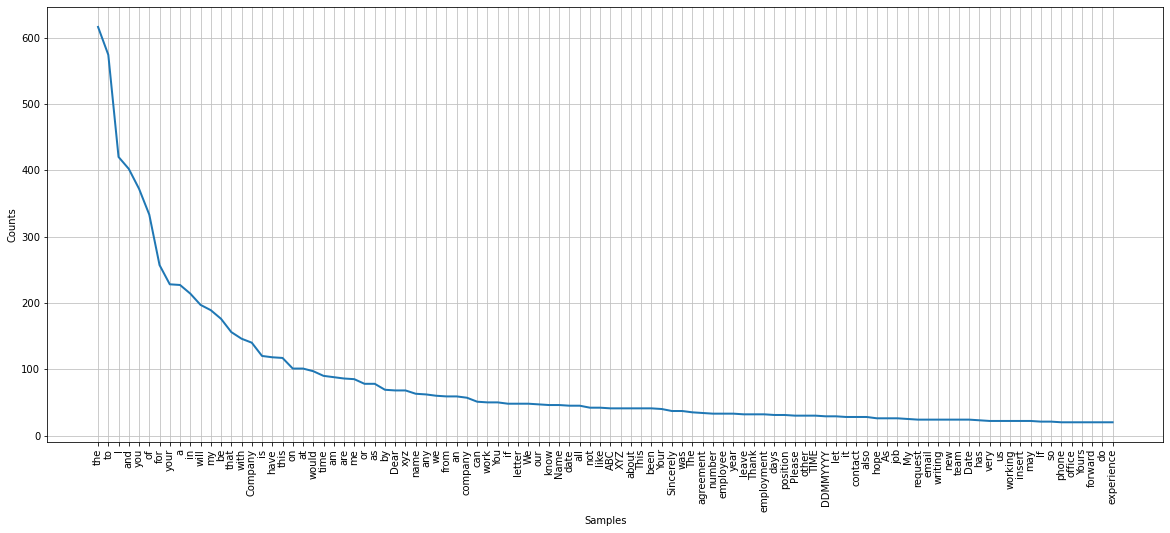

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))

freqd.plot(100,cumulative=False)
plt.show()

In [45]:
from keras.preprocessing.text import Tokenizer

In [46]:
sentence = ["df2"]

def print_bow(sentence: str) -> None:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence)
    sequences = tokenizer.texts_to_sequences(sentence)
    word_index = tokenizer.word_index 
    bow = {}
    for key in word_index:
        bow[key] = sequences[0].count(word_index[key])

    print(f"Bag of word sentence 1:\n{bow}")
    print(f'We found {len(word_index)} unique tokens.')

print_bow(sentence)

Bag of word sentence 1:
{'df2': 1}
We found 1 unique tokens.


<AxesSubplot:title={'center':'Stopwords in mails'}, xlabel='word'>

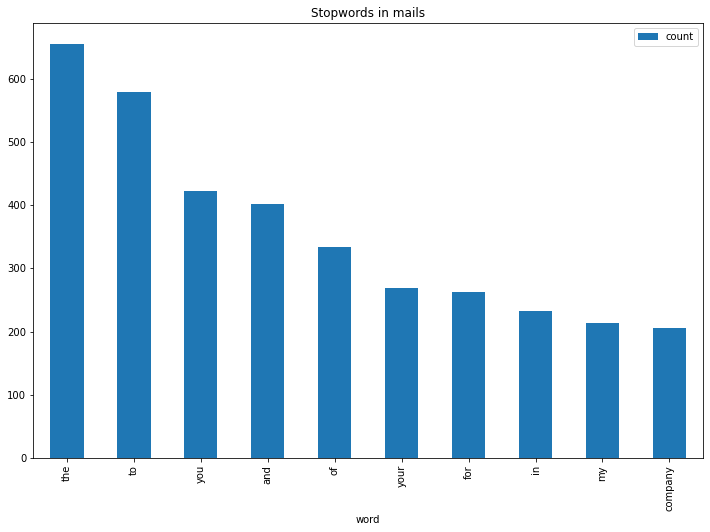

In [47]:
wf_df[0:10].plot.bar(x='word', figsize=(12,8), title='Stopwords in mails')

In [48]:
# all the stop words we have 
stop = stopwords.words('english')
new_words=('dear','name', 'work', 'email','please','sincerly','would','time','company','date','sincerely')
for i in new_words:
    stop.append(i)
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [49]:
def remove_stop_words(tokenizer,df2,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens1.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df2[feature] = doc_without_stopwords
    return 

In [50]:
df2

response  labels
0                 Sorry, kindly rephrase the question       8
1                       Sorry, can not understand you       8
2                     Please give me more information       8
3                               Not sure I understand       8
4   Dear ABC,\n I would like to request a XXX days...       7
..                                                ...     ...
91  Position \n Job title \n Your title will be Jo...       5
92  Position \n Job Title \n Your title will be Jo...       5
93  Congratulations on your new role.Your new empl...       5
94  Dear abc,\n We are excited to announce that we...       5
95  Position \n Job Title \n Your title will be Jo...       5

[96 rows x 2 columns]

In [51]:
df2['response_without_step_word'] = df2['response'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [52]:
df2

response  labels  \
0                 Sorry, kindly rephrase the question       8   
1                       Sorry, can not understand you       8   
2                     Please give me more information       8   
3                               Not sure I understand       8   
4   Dear ABC,\n I would like to request a XXX days...       7   
..                                                ...     ...   
91  Position \n Job title \n Your title will be Jo...       5   
92  Position \n Job Title \n Your title will be Jo...       5   
93  Congratulations on your new role.Your new empl...       5   
94  Dear abc,\n We are excited to announce that we...       5   
95  Position \n Job Title \n Your title will be Jo...       5   

                           response_without_step_word  
0                     Sorry, kindly rephrase question  
1                                   Sorry, understand  
2                             Please give information  
3                               Not sure I understand  
4   Dear ABC, I like request XXX days leave absenc...  
..                                                ...  
91  Position Job title Your title Job title, repor...  
92  Position Job Title Your title Job title, repor...  
93  Congratulations new role.Your new employment c...  
94  Dear abc, We excited announce offering extend ...  
95  Position Job Title Your title Job title, repor...  

[96 rows x 3 columns]

In [53]:
# function that performs text normalization steps

def text_normalization(text):
    text=str(text).lower() # text to lower case
    spl_char_text=re.sub(r'[^ a-z]','',text) # removing special characters
    tokens=nltk.word_tokenize(spl_char_text) # word tokenizing
    lema=wordnet.WordNetLemmatizer() # intializing lemmatization
    tags_list=pos_tag(tokens,tagset=None) # parts of speech
    lema_words=[]   # empty list 
    for token,pos_token in tags_list:
        if pos_token.startswith('V'):  # Verb
            pos_val='v'
        elif pos_token.startswith('J'): # Adjective
            pos_val='a'
        elif pos_token.startswith('R'): # Adverb
            pos_val='r'
        else:
            pos_val='n' # Noun
        lema_token=lema.lemmatize(token,pos_val) # performing lemmatization
        lema_words.append(lema_token) # appending the lemmatized token into a list
    
    return " ".join(lema_words) # returns the lemmatized tokens as a sentence 

In [54]:
from nltk.stem import wordnet # to perform lemmitization
from nltk import pos_tag # for parts of speech
text_normalization('Dear abc  I am very sorry for my behavior in the staff meeting this morning  I cut you off in the middle of your presentation and criticized your performance in front of the staff This was not only unprofessional but also simply disrespectful  I let my stress about a personal matter impact my management of the office  I have always said to you  and to all my employees  that I want this office to be a place where you all feel comfortable sharing ideas with one another  When I yelled at you publicly for a small error in your presentation I damaged that collaborative environment  I am taking steps to make sure I do not lose my temper in that way again  I am working to manage my stress so that I do not let it impact the way I interact with my employees  I also know how capable you are of conducting a terrific staff meeting  I would  therefore   love for you to lead the staff meeting next week  I am very sorry again  Feel free to contact me if you would like to discuss this matter further  Sincerely  xyz')

'dear abc i be very sorry for my behavior in the staff meeting this morning i cut you off in the middle of your presentation and criticize your performance in front of the staff this be not only unprofessional but also simply disrespectful i let my stress about a personal matter impact my management of the office i have always say to you and to all my employee that i want this office to be a place where you all feel comfortable share idea with one another when i yell at you publicly for a small error in your presentation i damage that collaborative environment i be take step to make sure i do not lose my temper in that way again i be work to manage my stress so that i do not let it impact the way i interact with my employee i also know how capable you be of conduct a terrific staff meeting i would therefore love for you to lead the staff meeting next week i be very sorry again feel free to contact me if you would like to discuss this matter far sincerely xyz'

In [55]:
df2['lemmatized_text']=df2['response_without_step_word'].apply(text_normalization) # applying the fuction to the dataset to get clean text
df2.tail()

response  labels  \
91  Position \n Job title \n Your title will be Jo...       5   
92  Position \n Job Title \n Your title will be Jo...       5   
93  Congratulations on your new role.Your new empl...       5   
94  Dear abc,\n We are excited to announce that we...       5   
95  Position \n Job Title \n Your title will be Jo...       5   

                           response_without_step_word  \
91  Position Job title Your title Job title, repor...   
92  Position Job Title Your title Job title, repor...   
93  Congratulations new role.Your new employment c...   
94  Dear abc, We excited announce offering extend ...   
95  Position Job Title Your title Job title, repor...   

                                      lemmatized_text  
91  position job title your title job title report...  
92  position job title your title job title report...  
93  congratulation new roleyour new employment con...  
94  dear abc we excite announce offering extend em...  
95  position job title your title job title report...

In [56]:
#Counting tokens again
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X1 = cv.fit_transform(df2['lemmatized_text'])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
wf_df1 = pd.DataFrame(words_freq)
wf_df1.columns = ['word', 'count']

wf_df1

word  count
0               arrange    402
1               recruit    334
2              indesign    262
3                  meet    233
4                pursue    214
...                 ...    ...
1667  titlecompensation      1
1668          calculate      1
1669    overachievement      1
1670             exceed      1
1671     transportation      1

[1672 rows x 2 columns]

<AxesSubplot:title={'center':'lemmatized text'}, xlabel='word'>

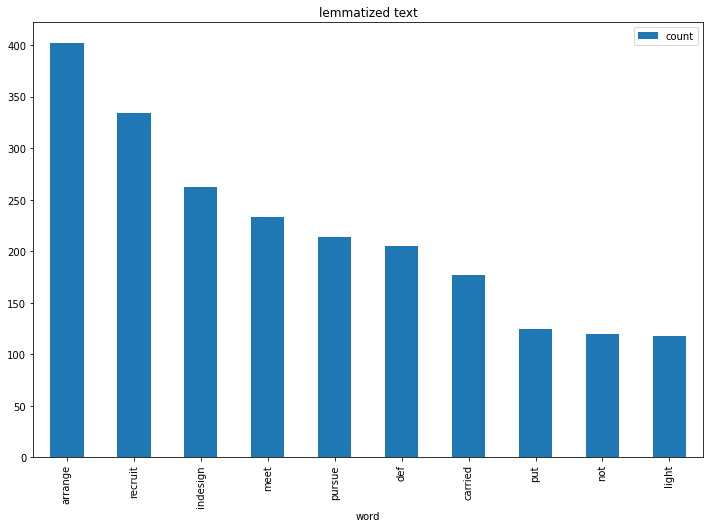

In [57]:
wf_df1[0:10].plot.bar(x='word', figsize=(12,8), title='lemmatized text')

In [58]:
#word frequency after removal of stopwords
freq = pd.Series(' '.join(df2['lemmatized_text']).split()).value_counts()[:50] # for top 20
freq

i               420
company         166
xyz             110
name             92
you              90
date             80
dear             68
abc              62
time             60
employee         59
day              58
thank            56
agreement        55
letter           50
year             49
we               48
know             47
like             45
sincerely        43
job              43
this             42
your             42
regard           41
leave            40
work             40
position         39
employment       38
write            36
number           36
the              36
option           34
title            32
also             31
please           30
let              30
contact          29
address          29
ddmmyyyy         29
make             28
compensation     28
team             28
require          28
subject          27
request          27
a                27
policy           27
hope             27
take             26
my               25
benefit          25


In [59]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

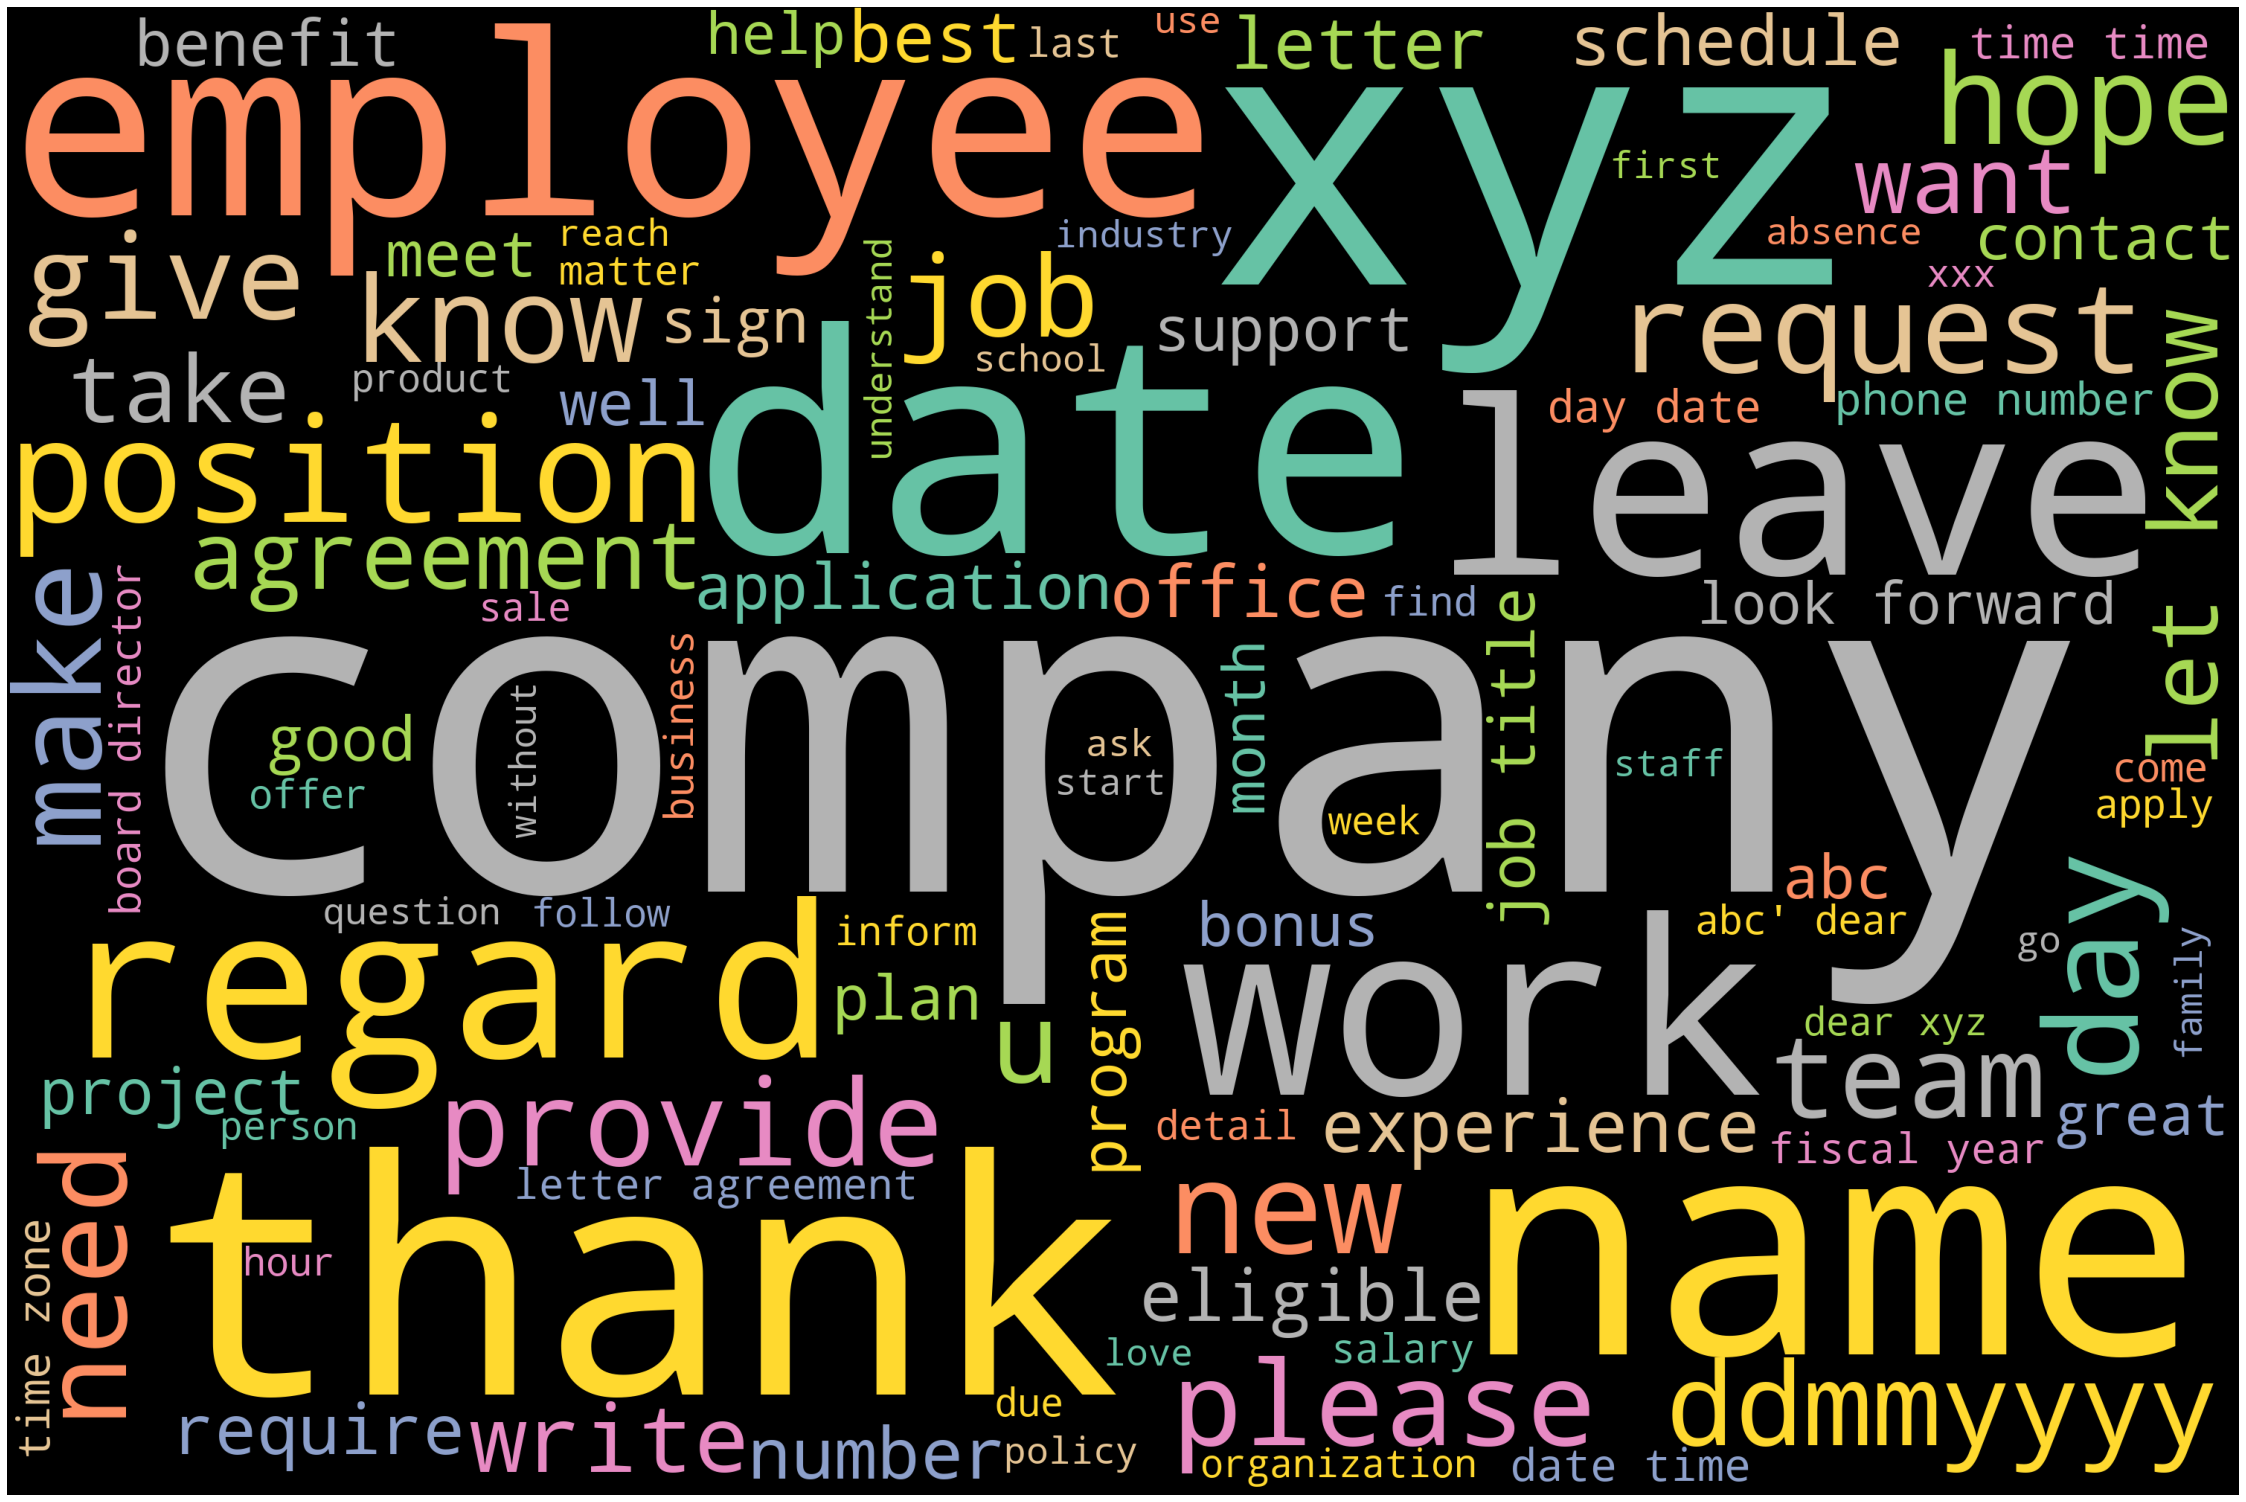

In [60]:
text = df2['lemmatized_text'].values 

wordcloud = WordCloud(width = 3000, height = 2000, background_color='black', max_words=100,colormap='Set2').generate(str(text))
plot_cloud(wordcloud)

In [61]:
df2['pca'] = (
   df2['response']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df2, 'pca', color='labels', title="PCA emails")

In [62]:
df2['tfidf'] = (
    df2['response']
    .pipe(hero.clean)
    .pipe(hero.tfidf)
)

df2['kmeans_labels'] = (
    df2['tfidf']
    .pipe(hero.kmeans, n_clusters=5)
    .astype(str)
)

df2['pca'] = df2['tfidf'].pipe(hero.pca)

hero.scatterplot(df2, 'pca', color='kmeans_labels', title="K-means emails")

D:\DATASCIENCEsoftware\Anaconda31stjan2021\Newfolder\lib\site-packages\sklearn\cluster\_kmeans.py:786: FutureWarning:

'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect

D:\DATASCIENCEsoftware\Anaconda31stjan2021\Newfolder\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).



### 8. Model Building

In [63]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [64]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [65]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [66]:
y_train[0].shape,y_test[0].shape

((9,), (9,))

In [67]:
X_train.shape

(90, 13)

In [68]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 9

In [69]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]

In [70]:
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    
    
    # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss = 'categorical_crossentropy',
              # optimizer = Adam(lr=0.001),
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [71]:
# define model
model = define_model(vocab_size, max_length)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 300)           47100     
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 64)            76864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 9)                 585       
Total params: 124,549
Trainable params: 124,549
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model.fit(X_train, y_train, epochs=500, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/500
3/3 [==============================] - 5s 336ms/step - loss: 2.1960 - accuracy: 0.1778 - val_loss: 2.1773 - val_accuracy: 0.2222

Epoch 00001: val_loss improved from inf to 2.17732, saving model to model-v1.h5
Epoch 2/500
3/3 [==============================] - 0s 33ms/step - loss: 2.0628 - accuracy: 0.4778 - val_loss: 2.1584 - val_accuracy: 0.1111

Epoch 00002: val_loss improved from 2.17732 to 2.15845, saving model to model-v1.h5
Epoch 3/500
3/3 [==============================] - 0s 37ms/step - loss: 1.9651 - accuracy: 0.4778 - val_loss: 2.1433 - val_accuracy: 0.1111

Epoch 00003: val_loss improved from 2.15845 to 2.14332, saving model to model-v1.h5
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 1.8592 - accuracy: 0.4778 - val_loss: 2.1286 - val_accuracy: 0.1111

Epoch 00004: val_loss improved from 2.14332 to 2.12863, saving model to model-v1.h5
Epoch 5/500
3/3 [==============================] - 0s 31ms/step - loss: 1.7548 - accuracy: 0.4778 - val

3/3 [==============================] - 0s 33ms/step - loss: 0.0615 - accuracy: 0.9889 - val_loss: 0.7453 - val_accuracy: 0.6667

Epoch 00037: val_loss improved from 0.75490 to 0.74529, saving model to model-v1.h5
Epoch 38/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0591 - accuracy: 0.9889 - val_loss: 0.7318 - val_accuracy: 0.6667

Epoch 00038: val_loss improved from 0.74529 to 0.73181, saving model to model-v1.h5
Epoch 39/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0554 - accuracy: 0.9889 - val_loss: 0.7217 - val_accuracy: 0.6667

Epoch 00039: val_loss improved from 0.73181 to 0.72170, saving model to model-v1.h5
Epoch 40/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0530 - accuracy: 0.9889 - val_loss: 0.7111 - val_accuracy: 0.6667

Epoch 00040: val_loss improved from 0.72170 to 0.71114, saving model to model-v1.h5
Epoch 41/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0500 - accuracy: 0.9889 - val_loss

3/3 [==============================] - 0s 29ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.5428 - val_accuracy: 0.7778

Epoch 00073: val_loss improved from 0.54476 to 0.54277, saving model to model-v1.h5
Epoch 74/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.5412 - val_accuracy: 0.7778

Epoch 00074: val_loss improved from 0.54277 to 0.54118, saving model to model-v1.h5
Epoch 75/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.5399 - val_accuracy: 0.7778

Epoch 00075: val_loss improved from 0.54118 to 0.53987, saving model to model-v1.h5
Epoch 76/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.5388 - val_accuracy: 0.7778

Epoch 00076: val_loss improved from 0.53987 to 0.53880, saving model to model-v1.h5
Epoch 77/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss

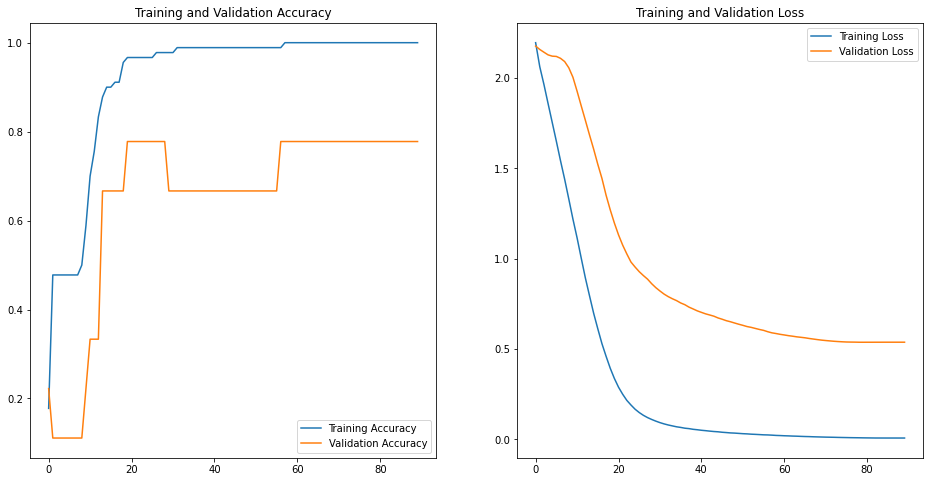

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [74]:
[np.argmax(i) for i in model.predict(X_test)][:10]

[0, 2, 1, 3, 4, 5, 6, 7, 8]

In [75]:
[np.argmax(i) for i in y_test][:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8]